# 3D Mesh Reconstruction from Cardiac Ultrasound

In [13]:
from neuralnet_pytorch.metrics import chamfer_loss
import numpy as np
import torch
from eval_dataset import RightVentricleDataset
import torch.nn.functional as f
from model import P2M_Model
from dice import compute_meandice, DiceLoss
import ipyvolume as ipv
import matplotlib.pyplot as plt
import cv2

## Predict

In [15]:
MODEL_PATH = "D:\\_Dissertation\\gcnn_rv\\eval\\NewEdgeLoss\\network_44.pth"

In [41]:
initial_mesh = np.load('data/mean_rv_dict.npy', allow_pickle=True).item()
tee_mean = np.load("data/my_new_init.npy", allow_pickle=True)
initial_mesh["points"] = tee_mean
triangles = initial_mesh["triangles"]
use_cuda = torch.cuda.is_available()
# use_cuda = False

In [42]:
eval_dataset = RightVentricleDataset(dataset_list_path="..//data")
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=1, shuffle=True,num_workers=1)

D:\_Dissertation\gcnn_rv_for_notebook


In [43]:
network = P2M_Model(227, 192, 3, initial_mesh['supports'], use_cuda)
network.load_state_dict(torch.load(MODEL_PATH))
if use_cuda:
    network.cuda()

Loading UNet from  D:\_Dissertation\gcnn_rv_for_notebook\model\model_178.pth


In [44]:
chamfer_dist, mse_dist, dice = [], [], [] 
pred_points, gt_points = [], []
pred_img, gt_img, initial_img = [], [], []

In [45]:
for i, data in enumerate(eval_dataloader, 0):
    img, _, pts, normal, _, _ = data
    init_pts = torch.tensor(initial_mesh['points'], dtype=torch.float32)
    if use_cuda:
        img = img.cuda()
        init_pts = init_pts.float().cuda()
        
    pred_pts_list, pred_feats_list, pred_img = network(img, init_pts)
    initial_img.append(img.detach().cpu())
    pred_points.append(pred_pts_list[0].detach().cpu())
    gt_points.append(pts.detach().cpu())
    
del data
del init_pts
del img
del pts
del normal
del _
torch.cuda.empty_cache()

In [56]:
chamfer_sum = 0
mse_sum = 0
for i in range(len(pred_points)):
    chamfer_sum += chamfer_loss(pred_points[i].unsqueeze(0), gt_points[i])
#     print(chamfer_loss(pred_points[i].unsqueeze(0), gt_points[i]))
    mse_sum += f.mse_loss(pred_points[i].unsqueeze(0), gt_points[i])

In [57]:
chamfer_measure = chamfer_sum/len(eval_dataloader)
mse_measure = mse_sum/len(eval_dataloader)

## Quantitative evaluation


#### Chamfer score

In [58]:
chamfer_measure

tensor(0.8467)

#### MSE Score

In [59]:
mse_measure

tensor(0.0008)

## Qualitative evaluation


#### Template Mesh
(which is going to be deformed)

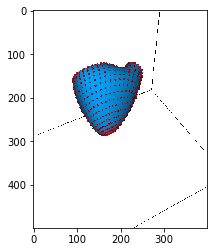

In [61]:
img = cv2.imread('initial_mesh.png', 1)
plt.imshow(img)

#### Reconstructed mesh

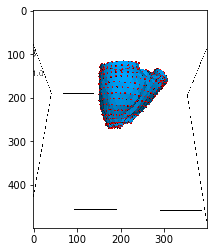

In [62]:
img = cv2.imread('generated_mesh.png', 1)
plt.imshow(img)

In [31]:
index = 0

In [32]:
x = pred_points[index].cpu().data.numpy()[:, 0] 
y = pred_points[index].cpu().data.numpy()[:, 1] 
z = pred_points[index].cpu().data.numpy()[:, 2] 

ipv.figure()
#     ipv.style.axes_off()
#     ipv.style.box_off()
ipv.plot_trisurf(x, y, z, triangles=triangles, color='orange')
ipv.scatter(x,y,z, marker='sphere', color='blue', size=0.7)
ipv.show()

#### Input Image

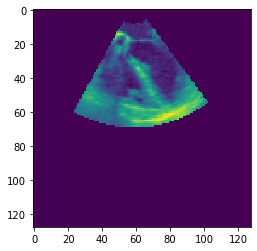

In [40]:
init_img = initial_img[index].data.numpy().squeeze()
plt.imshow(init_img[:,64,:])